In [1]:
import sys
sys.path.insert(0, '..')
from eda_import import *

In [2]:
adf = pd.read_csv('../__results/aca_pval_with_sc_info.csv')

In [3]:
assert adf.shape[0] == 11368

# Resolve trends computationally

In [4]:
bdf = adf.query('has_diff_aca == True').copy()
bdf.head(1)

,disease,gene_name,mkid,mclv,strand,aclv,N_on,T_on,N_off,T_off,fisher_exact_p,N_base,T_base,N_on_ratio,T_on_ratio,N2T_ratio_diff,diff_is_significant,N2T_ratio_change,N2T_ratio_change_sig,has_diff_aca,sc_list,src_list,num_sc
74,BLCA,BRCA1,chr17|BRCA1|-|41196318,41196318,-,41196313,13,401,6,13,0.000059,19,414,0.684211,0.968599,0.284389,True,up,up,True,41197695,protein_coding,1


In [5]:
bdf.shape

(576, 23)

In [6]:
bdf.gene_name.unique().shape

(33,)

In [7]:
# xs = np.sort(np.arange(0, 100, 10).tolist() + np.arange(100, 500, 20).tolist() + [25])
xs = np.arange(0, 500)
ys = []
for x in xs:
    _df = bdf.copy()
    _df['dist_mclv2aclv'] = np.abs(_df.mclv - _df.aclv)
    n = _df.query('dist_mclv2aclv > {0}'.format(x)).query('diff_is_significant == True').reset_index(drop=True).shape[0]
#     n = _df.query('dist_mclv2aclv <= {0}'.format(x)).reset_index(drop=True).shape[0]
    ys.append(n)

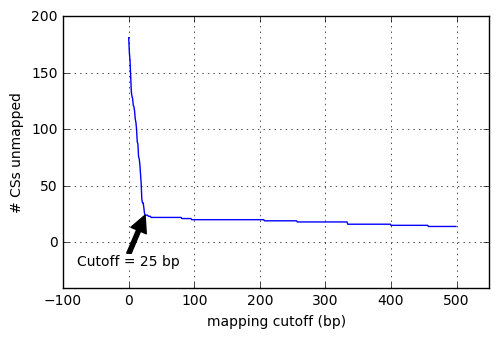

In [8]:
fig = plt.figure(figsize=(5.5, 3.5))
ax = fig.add_subplot(111)

my_cutoff = 25

ax.plot(xs, ys, ms=3)

idx = xs.tolist().index(my_cutoff)
# ax.scatter([25], ys[idx], marker='*', color='red', s=100, alpha=1)
ax.annotate('Cutoff = 25 bp', xy=(my_cutoff, ys[idx]), xytext=(0, -20), ha='center',
            arrowprops=dict(facecolor='black', shrink=0, width=3),
            bbox=dict(pad=0, fc='white', ec='none'),
            )

ax.set_xlim([-100, 550])
ax.set_ylim([-40, 200])
ax.set_xlabel('mapping cutoff (bp)')
ax.set_ylabel('# CSs unmapped')
# ax.set_xticks(np.arange(0, 201, 20))
ax.grid()

# plt.savefig('./figs/mappabilityCutoffSelection.jpeg', dpi=300)

In [9]:
mclv2aclv_cutoff = 25 # consistent with DA cutoff, maybe not necessary
bdf['dist_mclv2aclv'] = np.abs(bdf.mclv - bdf.aclv)
# bdf.query('dist_mclv2aclv > {0}'.format(mclv2aclv_cutoff)).query('diff_is_significant == True').reset_index(drop=True)

There are not that many such cases where the distance between mclv and aclv > cutoff, but some of them look really interesting, but they potentially novel and important sites!

#### For practical purposes, only consider successfully mapped ones when calculating a trend

In [10]:
bdf.mkid.unique().shape[0]

297

In [11]:
# mapped: successfully mapped to an annotated clv site, so we can start talking about stop codons now.
mapped = bdf.query('dist_mclv2aclv <= {0}'.format(mclv2aclv_cutoff)).copy()

In [12]:
mapped.query('diff_is_significant == True').mkid.unique().shape

(91,)

In [13]:
bdf.query('diff_is_significant == True').mkid.unique().shape

(111,)

In [14]:
mapped.query('diff_is_significant == True').mkid.unique().shape[0] / bdf.query('diff_is_significant == True').mkid.unique().shape[0]

0.8198198198198198

so ~82% of those kids concerned (after stripping) are successfully mapped

In [15]:
mapped.shape[0]

346

In [16]:
mapped.head(1)

,disease,gene_name,mkid,mclv,strand,aclv,N_on,T_on,N_off,T_off,fisher_exact_p,N_base,T_base,N_on_ratio,T_on_ratio,N2T_ratio_diff,diff_is_significant,N2T_ratio_change,N2T_ratio_change_sig,has_diff_aca,sc_list,src_list,num_sc,dist_mclv2aclv
74,BLCA,BRCA1,chr17|BRCA1|-|41196318,41196318,-,41196313,13,401,6,13,0.000059,19,414,0.684211,0.968599,0.284389,True,up,up,True,41197695,protein_coding,1,5


In [17]:
mapped[['mkid', 'num_sc']].drop_duplicates().num_sc.value_counts()

1    122
2    17 
3    2  
4    1  
Name: num_sc, dtype: int64

In [18]:
mapped[['mkid', 'num_sc']].drop_duplicates().query('num_sc > 1').shape[0] / mapped[['mkid', 'num_sc']].drop_duplicates().shape[0]

0.14084507042253522

so about 14% of CSs concerned are mapped to multiple annotated stop codons.

In [19]:
# remove those mapped_1sc to multiple sc as their corresponding 3'UTR length cannot be resolved at all 
# if only based on frequency
mapped_1sc = mapped.query('num_sc == 1').copy()
# convert 1-element list to a int, take first one by default?!
mapped_1sc['sc'] = mapped_1sc['sc_list'].apply(lambda i: int(i.split(', ')[0])).astype(int)
mapped_1sc.drop(['sc_list', 'num_sc'], inplace=True, axis=1)

Calculate utr length based on KLEAT clv (aka mclv in this context) (or aclv? they should be very close) and annotated stop codon

In [20]:
mapped_1sc['utr_len'] = mapped_1sc.apply(lambda row: abs(row.aclv - row.sc), axis=1)

In [21]:
mapped_1sc.head(2)

,disease,gene_name,mkid,mclv,strand,aclv,N_on,T_on,N_off,T_off,fisher_exact_p,N_base,T_base,N_on_ratio,T_on_ratio,N2T_ratio_diff,diff_is_significant,N2T_ratio_change,N2T_ratio_change_sig,has_diff_aca,src_list,dist_mclv2aclv,sc,utr_len
74,BLCA,BRCA1,chr17|BRCA1|-|41196318,41196318,-,41196313,13,401,6,13,0.000059,19,414,0.684211,0.968599,0.284389,True,up,up,True,protein_coding,5,41197695,1382
75,BLCA,BRCA1,chr17|BRCA1|-|41196822,41196822,-,41196822,15,323,4,91,1.000000,19,414,0.789474,0.780193,-0.009280,False,down,NaN,True,protein_coding,0,41197801,979


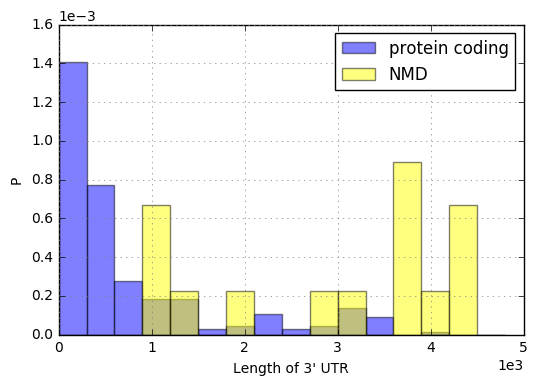

In [22]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
bins = np.arange(0, 5000, 300)

utr_len1 = mapped_1sc.query('src_list == "protein_coding"').utr_len
# utr_len1.plot.hist(ax=ax, bins=bins, histtype='step', normed=True, label='protein coding')
utr_len1.plot.hist(ax=ax, bins=bins, alpha=0.5, color='blue', normed=True, label='protein coding')

utr_len2 = mapped_1sc.query('src_list == "nonsense_mediated_decay"').utr_len
# utr_len2.plot.hist(ax=ax, bins=bins, histtype='step', normed=True, label='NMD')
utr_len2.plot.hist(ax=ax, bins=bins, alpha=0.5, color='yellow', normed=True, label='NMD')

ax.ticklabel_format(style='sci', scilimits=(0,0))
ax.set_xlabel("Length of 3' UTR")
ax.set_ylabel("P")
ax.legend()
ax.grid(color='gray')
# plt.savefig('./figs/NmdLong3UTR.jpeg', dpi=300)

In [23]:
utr_len1.mean()

2158.4155844155844

In [24]:
utr_len2.mean()

12721.777777777777

In [25]:
stats.ks_2samp(utr_len1.values, utr_len2.values)

Ks_2sampResult(statistic=0.73809523809523814, pvalue=6.5427930687879785e-16)

So NMD utr len tends to be much longer

In [26]:
mapped_1sc.src_list.value_counts()

protein_coding                             231
nonsense_mediated_decay                    36 
nonsense_mediated_decay, protein_coding    2  
Name: src_list, dtype: int64

In [27]:
# _df = mapped.sort_values('utr_len').query('utr_len == 0')
# _df[_df.src_list == ("protein_coding", )]

In [28]:
mapped_1sc.src_list.unique()

array(['protein_coding', 'nonsense_mediated_decay',
       'nonsense_mediated_decay, protein_coding'], dtype=object)

a number of them are tiny...

In [29]:
def init_trend(state):
    if state == 'up':
        # potential trend because utr are sorted by length already 
        pot = -1  # shortening
    elif state == 'down':
        pot = 1 # lengthening
    else:
        raise
    return pot

def define_trend_no_nan(changes):
    """changes should be sorted by utr length, and contain no nan values"""
    trend = 0
    if len(changes) <= 1:
        # there is no point talking about trend if only 1 possibility of 3'UTR length exists
        return trend
    
    transition_count = 0
    state = changes[0]
    trend = init_trend(state)
        
    for i in changes[1:]:
        if i != state:
            transition_count += 1
            state = i
    # print(transition_count)
    # should be exactly 1 transition, if above 1, see CHURC1, LUSC
    if transition_count != 1:
        trend = 0 # reset to undefined trend
    return trend

assert define_trend_no_nan(['up', 'down']) == -1 # shortening
assert define_trend_no_nan(['down', 'up']) == 1  # lengthening
assert define_trend_no_nan(['down']) == 0  # undefined
assert define_trend_no_nan(['up']) == 0  # undefined
assert define_trend_no_nan(['down', 'up', 'down']) == 0  # undefined
assert define_trend_no_nan(['up', 'down', 'up']) == 0  # undefined

def is_nan(val):
    """handles mix of float and string (bad design if you find this function useful)"""
    return True if isinstance(val, float) and np.isnan(val) else False


def define_trend(changes):
    """
    changes should be sorted by utr length, and possibly contain nan values
    
    changes should be partitioned after sorted by utr length, in order to assign a trend,
    otherwise unassigned. e.g.
        down, down, nan, up implies lengthening
        up, down, nan implies lengthening
        
    nan means no significant change, but they have to be there as they're evidence for an 
    alternative 3'UTR with a different length, esp. when only up or down is found for a given stop codon,
    hence for comparison purpose
    """
    if np.unique(changes).shape[0] == 1:
        return 0 # undefined, no trend can be defined
    
    if all([is_nan(_) for _ in changes]):
        # np.unique([np.nan, np.nan]) still has a shape of (2,)
        return 0
    
    if 'up' in changes and 'down' in changes:
        # then ignore nan
        changes = [_ for _ in changes if not is_nan(_)]
    # nan matters when there is only 'down' or 'up', and is 
    # converted to the opposite change, in relatively terms
    elif 'up' in changes:
        changes = [_ if not is_nan(_) else 'down' for _ in changes]
    elif 'down' in changes:
        changes = [_ if not is_nan(_) else 'up' for _ in changes ]
#     print(changes)
    return define_trend_no_nan(changes)

assert define_trend(['up', 'down']) == -1 # shortening
assert define_trend(['down', 'up']) == 1  # lengthening
assert define_trend(['down']) == 0  # undefined
assert define_trend(['down', 'up', 'down']) == 0  # undefined
assert define_trend(['up', 'down', 'up']) == 0  # undefined
# with nan
assert define_trend([np.nan, 'down', 'up']) == 1
assert define_trend(['down', 'down', np.nan]) == 1
assert define_trend(['up', 'down', np.nan]) == -1
assert define_trend(['up', np.nan]) == -1
assert define_trend(['up', 'up', np.nan]) == -1
assert define_trend(['down', np.nan]) == 1
assert define_trend(['down', 'down', np.nan]) == 1
assert define_trend(['down', 'up', np.nan]) == 1
assert define_trend([np.nan, 'up']) == 1
assert define_trend(['up', 'up', np.nan]) == -1
assert define_trend(['down', np.nan]) == 1
assert define_trend(['down', 'down', np.nan]) == 1
assert define_trend([np.nan, np.nan]) == 0

def sc_level_comp(grp_by_sc):
    """stop codon-level comparison"""
    changes = grp_by_sc.sort_values('utr_len').N2T_ratio_change_sig.values.tolist()
#     print(changes)
    return define_trend(changes)

def assign_utr_trend(grp):
    pots = grp.groupby('sc').apply(sc_level_comp)
    return pots

In [30]:
sc_level_trends = mapped_1sc.groupby(['disease', 'gene_name']).apply(assign_utr_trend)

In [31]:
sc_level_trends.head(2)

disease  gene_name  sc      
BLCA     BRCA1      41197695    0
                    41197801    0
dtype: int64

In [32]:
trends_df = sc_level_trends.to_frame('trend').reset_index().groupby(['disease', 'gene_name']).apply(lambda g: g.trend.unique()).to_frame('sc_level_trends')

In [33]:
TRENDS_DD = {
    -1: 'shortening',
    0: 'undefined',
    1: 'lengthening'
}

In [34]:
def resolve_trends(trends):
    """resolve possibly multiple trends into one, e.g.
    [shortening, undefined] => shortening
    [lengthening, undefined] => lengthening
    [lengthening, undefined, shortening] => undefined
    [undefined] => undefined
    """
    trends = np.unique(trends)
    if len(trends) == 1:
        return trends[0]
    elif len(trends) == 2:
        if 0 in trends:
            return sum(trends)
        else:
            return 0
    else:
        return 0
        
assert resolve_trends([0]) == 0
assert resolve_trends([1]) == 1
assert resolve_trends([-1]) == -1
assert resolve_trends([-1, 1]) == 0
assert resolve_trends([-1, 0]) == -1
assert resolve_trends([1, 0]) == 1
assert resolve_trends([-1, 0, 1]) == 0

In [35]:
trends_df['resolved_trend'] = trends_df.sc_level_trends.apply(resolve_trends)
trends_df.reset_index(inplace=True)

In [36]:
trends_df['resolved_trend_name'] = trends_df.resolved_trend.apply(lambda t: TRENDS_DD[t])

In [37]:
trends_df.head()

,disease,gene_name,sc_level_trends,resolved_trend,resolved_trend_name
0,BLCA,BRCA1,[0],0,undefined
1,BRCA,AKT2,[0],0,undefined
2,BRCA,CCNE1,[1],1,lengthening
3,BRCA,EZH2,[0],0,undefined
4,BRCA,FGF2,[-1],-1,shortening


In [38]:
trends_df.resolved_trend_name.value_counts()

undefined      45
shortening     16
lengthening    16
Name: resolved_trend_name, dtype: int64

In [39]:
trends_df.shape

(77, 5)

In [40]:
trends_df.query('resolved_trend != 0').gene_name.unique().shape

(17,)

In [41]:
assert trends_df.query('disease == "UCEC"').query('gene_name == "RNF43"').resolved_trend_name.values[0] == 'lengthening'

In [42]:
assert trends_df.query('disease == "KIRC"').query('gene_name == "RNF43"').resolved_trend_name.values[0] == 'shortening'

# Now with resolved trends, plot the table like plot

In [43]:
diff_aca_df = bdf.copy()

In [44]:
diff_aca_df.disease.unique().shape

(13,)

In [45]:
aca_dises = sorted(diff_aca_df.disease.unique())
print(aca_dises)

['BLCA', 'BRCA', 'COAD', 'HNSC', 'KICH', 'KIRC', 'KIRP', 'LIHC', 'LUAD', 'LUSC', 'PRAD', 'THCA', 'UCEC']


so no STAD

In [46]:
aca_genes = sorted(diff_aca_df.gene_name.unique())

In [47]:
aca_mat = diff_aca_df[['disease', 'gene_name']].drop_duplicates()

incorporate trend information for genes

In [48]:
def assign_trend(row):
    res = trends_df.query('gene_name == "{0}"'.format(row.gene_name)).query('disease == "{0}"'.format(row.disease))
    try:
        assert res.shape[0] == 1
        return res.resolved_trend.values[0]
    except:
        print(row.gene_name, row.disease, res)
        return 0 # as undefined, this could be due the corresponding transcripts are not protein_coding ones

In [49]:
aca_mat['trend'] = aca_mat.apply(assign_trend, axis=1)

In [50]:
# aca_mat.to_csv('./data/aca_trends.csv', index=False)

In [51]:
aca_mat.trend.value_counts().to_frame().T

,0,-1,1
trend,45,16,16


In [52]:
aca_mat = aca_mat.pivot(index='gene_name', columns='disease', values='trend').fillna(-2)
# aca_mat = aca_mat.pivot(index='disease', columns='gene_name', values='trend').fillna(-2)

In [53]:
aca_mat += 2 # shift the values for imshow

In [54]:
aca_mat.head(2)

disease,BLCA,BRCA,COAD,HNSC,KICH,KIRC,KIRP,LIHC,LUAD,LUSC,PRAD,THCA,UCEC
gene_name,,,,,,,,,,,,,
AKT2,0.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
ALK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0


In [55]:
clv_sc_df = pd.read_csv('../__results/annotated-clv-sc-mapping.csv')

In [56]:
aca_mat.index.shape[0]

33

In [57]:
sc_count_dd = clv_sc_df.groupby('gene_name').apply(lambda g: g.sc.unique().shape[0])

In [58]:
clv_count_dd = clv_sc_df.groupby('gene_name').apply(lambda g: g.aclv.unique().shape[0])

In [59]:
aca_mat['num_sc'] = list(map(lambda g: sc_count_dd[g], aca_mat.index.values))

In [60]:
# aca_mat['label'] = list(map(lambda g: '{0} ({1}, {2})'.format(g, sc_count_dd[g], clv_count_dd[g]), aca_mat.index.values))
aca_mat['label'] = list(map(lambda g: r'\textit{{{0}}} ({1}, {2})'.format(g, sc_count_dd[g], clv_count_dd[g]), aca_mat.index.values))

In [61]:
aca_mat.reset_index(inplace=True) # just for sorting purpose
aca_mat.index = aca_mat.gene_name

In [62]:
aca_mat.head(2)

disease,gene_name,BLCA,BRCA,COAD,HNSC,KICH,KIRC,KIRP,LIHC,LUAD,LUSC,PRAD,THCA,UCEC,num_sc,label
gene_name,,,,,,,,,,,,,,,,
AKT2,AKT2,0.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,8,"\textit{AKT2} (8, 9)"
ALK,ALK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2,"\textit{ALK} (2, 3)"


In [63]:
# aca_mat.sort_values(['num_sc', 'gene_name'], inplace=True)
aca_mat.sort_values(['gene_name'], inplace=True)

In [64]:
aca_mat = aca_mat.T

In [65]:
# aca_mat_vals = aca_mat.loc[aca_dises].astype(int)
aca_mat_vals = aca_mat.loc[aca_dises].astype(int)

In [66]:
# http://stackoverflow.com/questions/9707676/defining-a-discrete-colormap-for-imshow-in-matplotlib
# BS: bootstrap
BS_BLUE = (np.array([2, 117, 216]) / 255).tolist()
BS_RED  = (np.array([217, 83, 79]) / 255).tolist()
# cust_cmap = matplotlib.colors.ListedColormap(['white', BS_BLUE, 'gray', BS_RED])

SHORTENING_COLOR = '#20948B'
LENGTHENING_COLOR = '#DE7A22'
cust_cmap = mpl.colors.ListedColormap([
        'white',
        SHORTENING_COLOR, 
#         'gray',
        '#C0C0C0', # light gray
        LENGTHENING_COLOR])

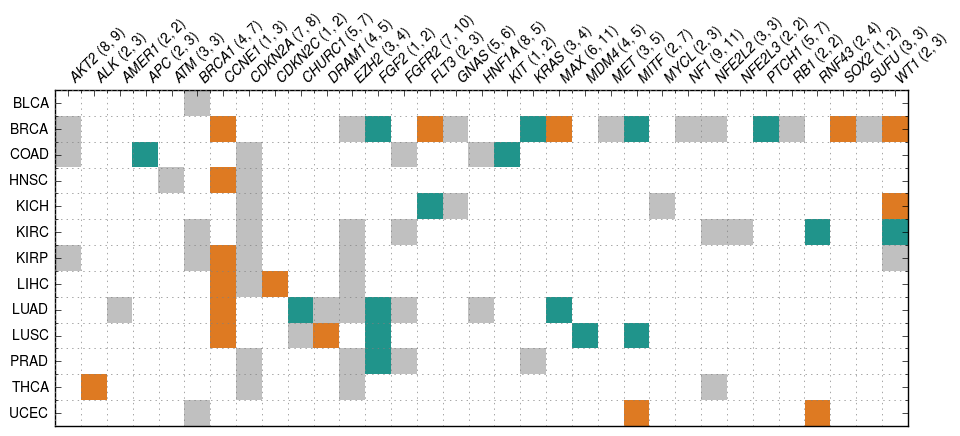

In [67]:
mpl.rc('text.latex', preamble=r'\usepackage{sfmath}')
mpl.rc('text', usetex = True)

# http://stackoverflow.com/questions/24190858/matplotlib-move-ticklabels-between-ticks
fig = plt.figure(figsize=(11, 6.2))
ax = fig.add_subplot(111)
ax.xaxis.tick_top()
_ = ax.imshow(aca_mat_vals.values, interpolation='none', cmap=cust_cmap, vmin=0, vmax=3)
_ = ax.set_xticks(np.arange(aca_mat_vals.shape[1]), minor=False)
_ = ax.set_yticks(np.arange(aca_mat_vals.shape[0]), minor=False)
# http://stackoverflow.com/questions/14852821/aligning-rotated-xticklabels-with-their-respective-xticks
_ = ax.set_xticklabels(aca_mat.loc['label'].values, rotation=45, horizontalalignment='left')
_ = ax.set_yticklabels(aca_mat_vals.index.values)

# adding edge lines
# xlim = ax.get_xlim()
# ylim = ax.get_ylim()
# for i in np.arange(0.5, aca_mat_vals.shape[1], 1):
#     ax.plot([i, i], ylim, '-', lw=0.5, color='black')
_ = ax.set_xticks(np.arange(-0.5, aca_mat_vals.shape[1]), minor=True)
_ = ax.set_yticks(np.arange(-0.5, aca_mat_vals.shape[0]), minor=True)
ax.grid(color='gray', which='minor')
# plt.savefig('./figs/trend_summary_tab.jpg', dpi=500, bbox_inches='tight')